In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
astunparse                   1.6.3
cachetools                   5.3.1
certifi                      2023.5.7
charset-normalizer           3.1.0
contourpy                    1.1.0
cycler                       0.11.0
flatbuffers                  23.5.26
fonttools                    4.41.0
gast                         0.4.0
google-auth                  2.21.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.56.0
h5py                         3.9.0
idna                         3.4
keras                        2.13.1
kiwisolver                   1.4.4
libclang                     16.0.0
Markdown                     3.4.3
MarkupSafe                   2.1.3
matplotlib                   3.7.2
numpy                        1.23.5
oauthlib                     3.2.2
opencv-python                4.8.0.74
opt-einsum                   3.3.0
pa

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install --upgrade pip


  Using cached pip-23.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


In [46]:
import tensorflow as tf
import os

    

In [4]:
import cv2
import imghdr

C:\Users\Chris\AppData\Local\Temp\ipykernel_9576\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data'
os.listdir(data_dir)


['nontoxicfolder', 'toxicfolder']

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    print(image_class)


nontoxicfolder
toxicfolder


In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
           # load data

Image not in ext list data\nontoxicfolder\dummyfile2
Image not in ext list data\toxicfolder\dummyfile


In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 135 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
# get another batch from iterator
batch = data_iterator.next()
#images as numpy arrays
scaled = batch[0] / 255
scaled.max()

1.0

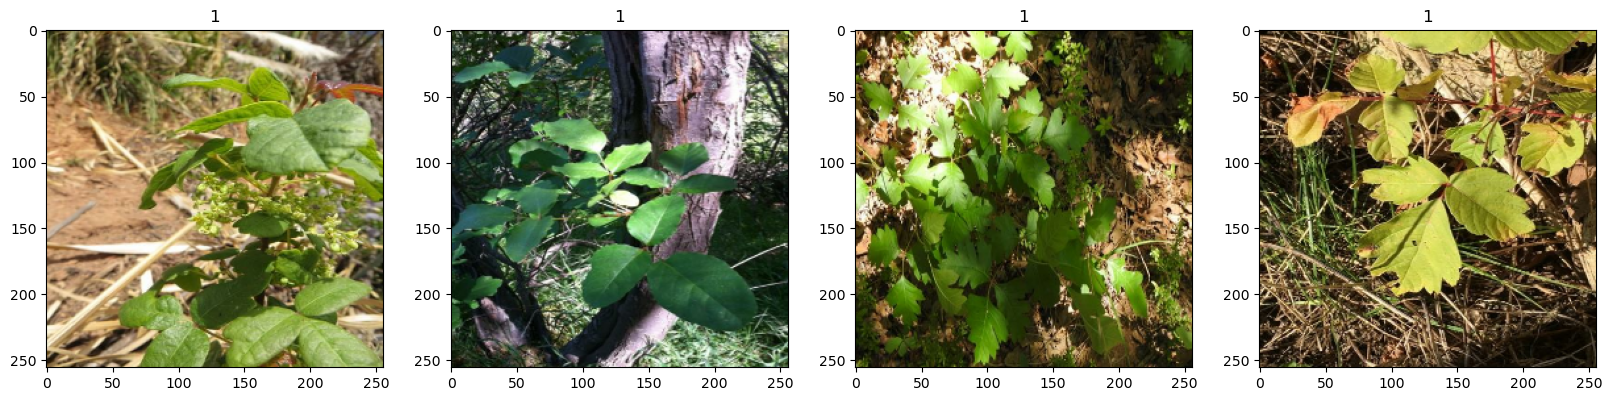

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    #0 = non toxic 1= toxic

In [13]:
#pre-processing step
# x independent features y is target variable - lables
data = data.map(lambda x,y: (x/255, y))


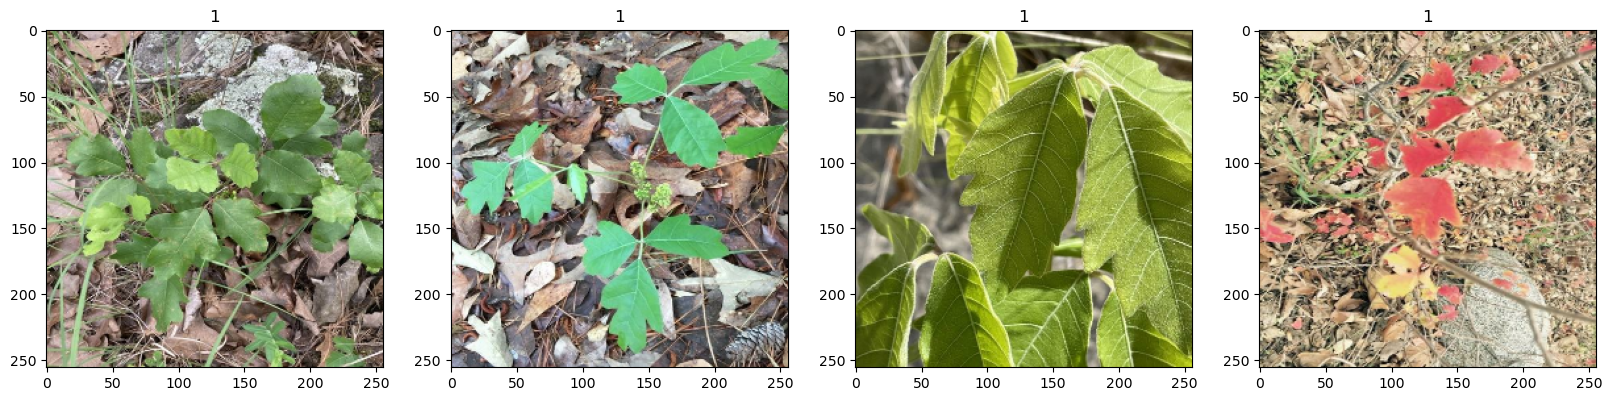

In [14]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


In [15]:
len(data)
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1


In [16]:

train_size+val_size+test_size


6

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
# convolution has 16 filters, 3 by 3 pixel size, stride of 1, relu take below zero to zero and keeps positive the same
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D()) # condense info
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten()) 
model.add(Dense(256, activation='relu')) # fully connected layers
model.add(Dense(1, activation='sigmoid')) # sigmoid range gets a single output 0 or 1 

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
# adam optimizer, specifiy loss and metric accuracy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [24]:
logdir = 'logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 13s 3s/step - loss: 1.1658 - accuracy: 0.5000 - val_loss: 0.7028 - val_accuracy: 0.4872
Epoch 2/20
3/3 [==============================] - 13s 4s/step - loss: 0.7326 - accuracy: 0.4375 - val_loss: 0.7068 - val_accuracy: 0.3590
Epoch 3/20
3/3 [==============================] - 12s 4s/step - loss: 0.6958 - accuracy: 0.4688 - val_loss: 0.6557 - val_accuracy: 0.7179
Epoch 4/20
3/3 [==============================] - 12s 4s/step - loss: 0.6610 - accuracy: 0.6250 - val_loss: 0.6489 - val_accuracy: 0.6154
Epoch 5/20
3/3 [==============================] - 12s 4s/step - loss: 0.6489 - accuracy: 0.6146 - val_loss: 0.6930 - val_accuracy: 0.5641
Epoch 6/20
3/3 [==============================] - 12s 4s/step - loss: 0.5913 - accuracy: 0.6875 - val_loss: 0.6021 - val_accuracy: 0.6154
Epoch 7/20
3/3 [==============================] - 12s 4s/step - loss: 0.6271 - accuracy: 0.6562 - val_loss: 0.5802 - val_accuracy: 0.8974
Epoch 8/20
3/3 [==================

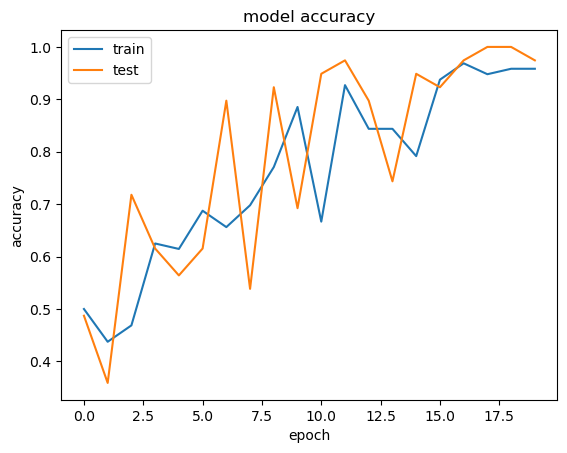

In [27]:
# Interpreting the data and results
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

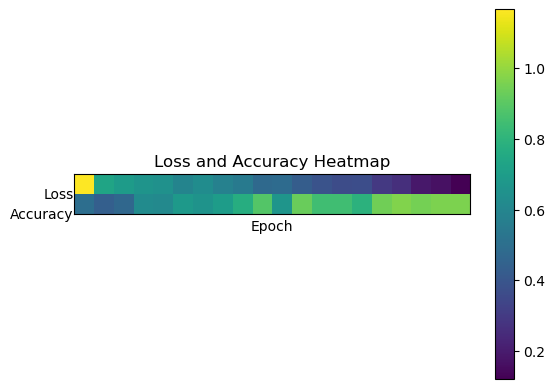

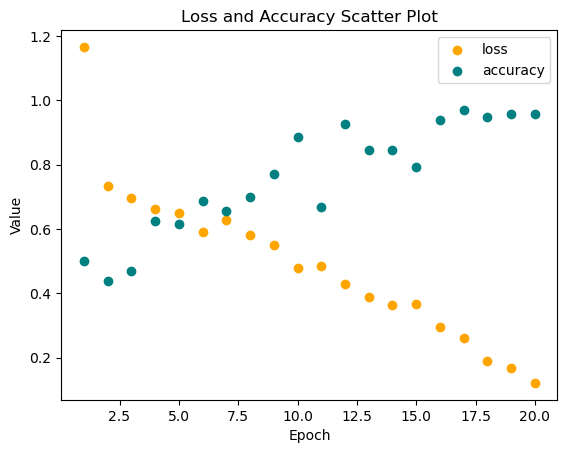

In [28]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Epoch')
    plt.ylabel('')
    plt.xticks([])  # Hide x-axis tick labels
    plt.yticks([])  # Hide y-axis tick labels
    plt.title('Loss and Accuracy Heatmap')
    plt.text(-0.5, 0.5, 'Loss', rotation=0, ha='right', va='center')
    plt.text(-0.5, 1.5, 'Accuracy', rotation=0, ha='right', va='center')
    plt.show()



# Create a 2D array with loss values
loss_array = np.array(hist.history['loss']).reshape(1, -1)

# Create a 2D array with accuracy values
accuracy_array = np.array(hist.history['accuracy']).reshape(1, -1)

# Concatenate the loss and accuracy arrays vertically
data_array = np.concatenate((loss_array, accuracy_array), axis=0)

# Plot the heatmap
heatmap2d(data_array)

epochs = len(hist.history['accuracy'])

# Create a list of epoch numbers
x = list(range(1, epochs + 1))

# Create a scatter plot for loss
plt.scatter(x, hist.history['loss'], color='orange', label='loss')

# Create a scatter plot for accuracy
plt.scatter(x, hist.history['accuracy'], color='teal', label='accuracy')

plt.title('Loss and Accuracy Scatter Plot')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

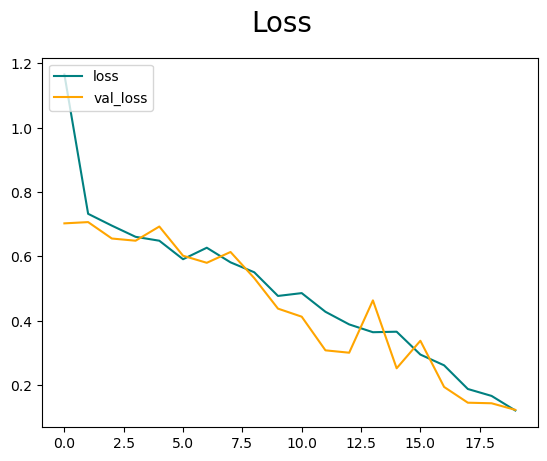

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

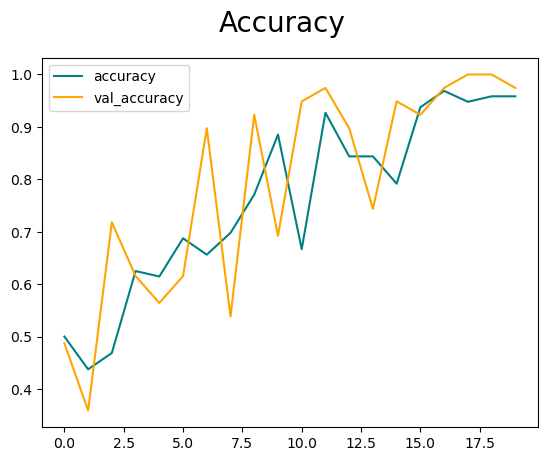

In [30]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [31]:
import cv2

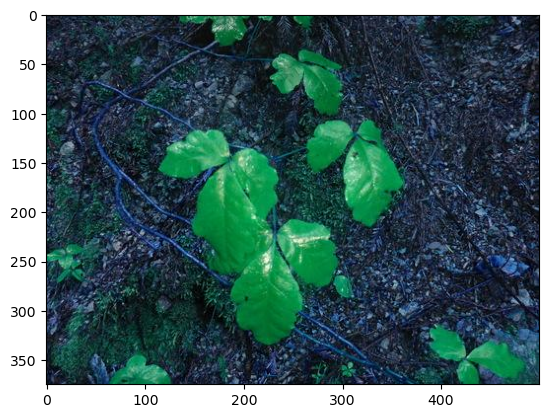

In [32]:
img = cv2.imread('toxictest.jpg')
plt.imshow(img)
plt.show()

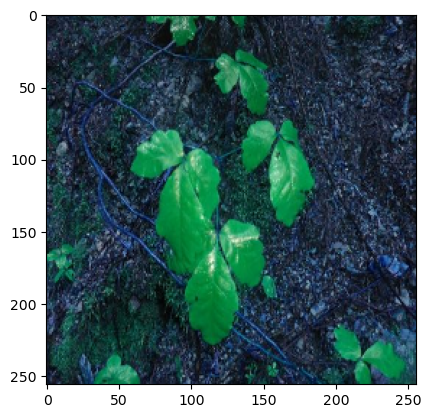

In [33]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [34]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 278ms/step


In [35]:
yhat

array([[0.8178041]], dtype=float32)

In [36]:
if yhat > 0.5: 
    print(f'Toxic')
else:
    print(f'Non-Toxic')

Toxic


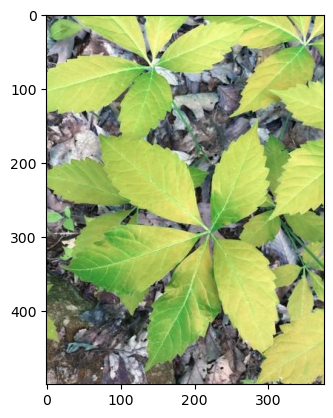

In [37]:
img = cv2.imread('nontoxictest.jpg')
plt.imshow(img)
plt.show()

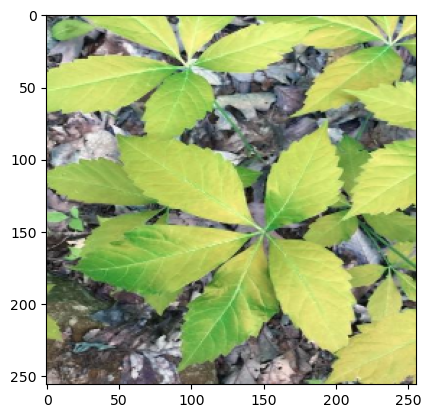

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 91ms/step


In [40]:
yhat

array([[0.841121]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Toxic')
else:
    print(f'Non-Toxic')

Toxic


In [42]:
from tensorflow.keras.models import load_model


In [43]:
model.save(os.path.join('models','posionClassifer.h5'))

C:\Users\Chris\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
#new_model = load_model('posionClassifer.h5')

In [61]:
#new_model.predict(np.expand_dims(resize/255, 0))

In [44]:
!pip install Pillow

import tkinter as tk
from tkinter import *
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
from tkinter import messagebox

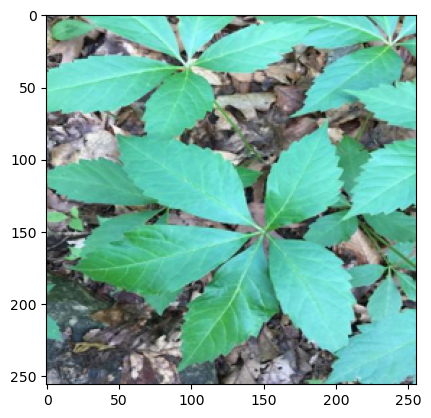

1/1 [==============================] - 0s 71ms/step
Toxic


In [45]:
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import IPython
import tensorflow as tf

upload_images = []

def upload_file(uploaded_images, frame):
    #print("upload being called")
    f_types = [('Jpg Files', '*.jpg'), ('PNG Files', '*.png')]
    filenames = filedialog.askopenfilenames(multiple=True, filetypes=f_types)
    col = 1  # start from column 1
    row = 3  # start from row 3
    for f in filenames:
        uploadedimg = Image.open(f)  # read the image file
        uploadedimg = uploadedimg.resize((100, 100))  # new width & height
        uploadedimg_tk = ImageTk.PhotoImage(uploadedimg)  # Store as a reference
        e1 = tk.Label(frame, image=uploadedimg_tk)  # Assign the image to the label
        e1.grid(row=row, column=col)
        e1.image = uploadedimg_tk  # Keep a reference by attaching it to a widget attribute
        if col == 3:  # start new line after the third column
            row += 1  # start with the next row
            col = 1  # start with the first column
        else:  # within the same row
            col += 1  # increase to the next column
        uploaded_images.append(f)  # Add the file path to the list


def makeaprediction():
    global uploaded_images

    if not uploaded_images:
        print("Please upload an image first.")
        return

    try:
        # Retrieve the last uploaded image file path
        file_path = uploaded_images[-1]

        img_pil = Image.open(file_path)
        img_pil = img_pil.resize((256, 256))
        img_np = np.array(img_pil)
        img = img_np.astype(np.float32) / 255.0

        plt.imshow(img)
        plt.show()

        resize = tf.image.resize(img, (256, 256))
        resize = tf.cast(resize, tf.float32)
        #  plt.imshow(resize.numpy().astype(int))
        #   plt.show()

        yhat = model.predict(np.expand_dims(resize, 0))
        if yhat > 0.5:
            print(f'Toxic')

        else:
            print(f'Non-Toxic')

    except Exception as e:
        print(f"An error occurred: {str(e)}")


def show_login():
    login_frame.pack()

def show_page2():
    global uploaded_images
    page1_frame.pack_forget()  # Hide page1 frame
    login_frame.pack_forget()  # Hide login frame
    page2_frame.pack()  # Show page2 frame

    uploaded_images.clear()  # Clear the uploaded images list

def login():
    global uploaded_images
    username = username_entry.get()
    password = password_entry.get()
    if username == "admin" and password == "admin":
        messagebox.showinfo(title="Login Success", message="You successfully logged in.")
        uploaded_images = []
        show_page2()
        
    elif username == "admin2" and password == "admin2":
          messagebox.showinfo(title="Login Success", message="You successfully logged in.")
          uploaded_images = []
          show_page2()
        
    else:
        messagebox.showerror(title="Error", message="Invalid login.")


root = tk.Tk()
root.title("Capstone")
root.geometry('450x500')
root.configure(bg='DarkSeaGreen1')

# Create frames for different views
login_frame = tk.Frame(root, bg='DarkSeaGreen1')
page1_frame = tk.Frame(root, bg='DarkSeaGreen1')
page2_frame = tk.Frame(root, bg='DarkSeaGreen1')

# Creating widgets for login frame
login_label = tk.Label(login_frame, text="Login", bg='cornsilk2', font=("Arial", 30))
username_label = tk.Label(login_frame, text="Username", fg='black', font=("Arial", 16))
username_entry = tk.Entry(login_frame, font=("Arial", 16))
password_entry = tk.Entry(login_frame, show="*", font=("Arial", 16))
password_label = tk.Label(login_frame, text="Password", font=("Arial", 16))
login_button = tk.Button(login_frame, text="Login", font=("Arial", 16), command=login)

# Placing widgets on login frame
login_label.pack(pady=40)
username_label.pack()
username_entry.pack(pady=20)
password_label.pack()
password_entry.pack(pady=20)
login_button.pack(pady=30)

# Creating widgets for page1 frame
page1_label = tk.Label(page1_frame, text='Upload Files & Make A Prediction', width=30, bg='cornsilk2', font=('times', 18, 'bold'))
page1_label.grid(row=1, column=1, columnspan=4, sticky="news", pady=25)
page1_button = tk.Button(page1_frame, text='Upload Files', width=15, pady=10, command=lambda: upload_file(uploaded_images, page1_frame))
page1_button.grid(row=2, column=1, columnspan=4)
page1_predict_button = tk.Button(page1_frame, text='Predict', width=15, pady=10, command=makeaprediction)
page1_predict_button.grid(row=3, column=1, columnspan=4)

# Creating widgets for page2 frame
page2_label = tk.Label(page2_frame, text='Upload Files & Make A Prediction', width=30, bg='cornsilk2', font=('times', 18, 'bold'))
page2_label.grid(row=1, column=1, columnspan=4, sticky="news", pady=25)
page2_button = tk.Button(page2_frame, text='Upload Files', width=15, pady=10, command=lambda: upload_file(uploaded_images, page2_frame))
page2_button.grid(row=2, column=1, columnspan=4)
page2_predict_button = tk.Button(page2_frame, text='Predict', width=15, pady=10, command=makeaprediction)
page2_predict_button.grid(row=3, column=1, columnspan=4)

# Initially show the login frame
show_login()

root.mainloop()


    
